## Apple Health Processor

-----

## Dependencies and Libraries

In [64]:
from datetime import date, datetime, timedelta as td
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [ ]:
#Backlog
#add vertical lines to mark surgery & novo start dates
#add h line to mark target weight
#basically add summaries and goals

#process workout data & calories burned
#ideally create single merged data table of daily fitness stats


------

## Steps

In [2]:
steps = pd.read_csv("data/StepCount.csv")
# steps.tail()

### Correct time zone to EST and capture time properties

In [3]:
# parse out date and time elements as EST time
steps['startDate'] = pd.to_datetime(steps['startDate'], utc=True).dt.tz_convert('EST')
steps['endDate'] = pd.to_datetime(steps['endDate'], utc=True).dt.tz_convert('EST')
steps['date'] = steps['startDate'].dt.strftime('%Y-%m-%d')
steps['year_month'] = steps['startDate'].dt.strftime('%Y-%m')
steps['year'] = steps['startDate'].dt.year
steps['month'] = steps['startDate'].dt.month
steps['day'] = steps['startDate'].dt.day
steps['hour'] = steps['startDate'].dt.hour
steps['dow'] = steps['startDate'].dt.weekday
steps['doy'] = steps['startDate'].dt.dayofyear

#drop irrelevant columns
steps = steps.drop(['device', 'creationDate'], axis=1)
# steps.head()

### Use Only Watch Steps, Remove Phone Steps

In [4]:
# drop phone steps
steps = steps[steps.sourceName == 'Greg’s Apple\xa0Watch']
steps.tail()

,sourceName,sourceVersion,type,unit,startDate,endDate,value,date,year_month,year,month,day,hour,dow,doy
106895,Greg’s Apple Watch,6.1.3,StepCount,count,2020-04-14 17:43:16-05:00,2020-04-14 17:44:15-05:00,44,2020-04-14,2020-04,2020,4,14,17,1,105
106896,Greg’s Apple Watch,6.1.3,StepCount,count,2020-04-14 17:44:15-05:00,2020-04-14 17:44:51-05:00,38,2020-04-14,2020-04,2020,4,14,17,1,105
106897,Greg’s Apple Watch,6.1.3,StepCount,count,2020-04-14 17:45:27-05:00,2020-04-14 17:45:42-05:00,34,2020-04-14,2020-04,2020,4,14,17,1,105
106898,Greg’s Apple Watch,6.1.3,StepCount,count,2020-04-14 17:47:32-05:00,2020-04-14 17:48:26-05:00,18,2020-04-14,2020-04,2020,4,14,17,1,105
106899,Greg’s Apple Watch,6.1.3,StepCount,count,2020-04-14 17:49:22-05:00,2020-04-14 17:49:27-05:00,5,2020-04-14,2020-04,2020,4,14,17,1,105


### Merge Fitbit data

In [5]:
# Read fitbit csv
fb = pd.read_csv('data/fitbit_master.csv')

# parse out date and time elements as EST time
fb['Date'] = pd.to_datetime(fb['Date'])#.dt.tz_convert('EST')
fb['date'] = fb['Date'].dt.strftime('%Y-%m-%d')
fb['year_month'] = fb['Date'].dt.strftime('%Y-%m')
fb['year'] = fb['Date'].dt.year
fb['month'] = fb['Date'].dt.month
fb['day'] = fb['Date'].dt.day
fb['dow'] = fb['Date'].dt.weekday
fb['doy'] = fb['Date'].dt.dayofyear

# #drop irrelevant columns
# fb = fb.drop(['Date', 'Calories Burned', 'Distance', 'Floors', 'Minutes Sedentary', 'Minutes Lightly Active', 'Minutes Fairly Active', 'Minutes Very Active','Activity Calories'], axis=1)

fb2=fb[['date', 'Steps']]
#drop rows that overlap apple watch
fb2=fb2.iloc[:-2,:]

# fb.head()
# fb2.tail()

-----

## Merge Fitbit Data

In [149]:
# Aggregate apple watch data by date
steps_by_date = steps.groupby(['date'])['value'].sum().reset_index(name='Steps')

#merge with fitbit data
steps_by_date = pd.concat([fb2, steps_by_date], ignore_index=True)

# print(steps_by_date.head())
print(steps_by_date.tail())

            date  Steps
1255  2020-04-10   4247
1256  2020-04-11  12625
1257  2020-04-12   6458
1258  2020-04-13   7622
1259  2020-04-14  16835


### Rolling average

In [151]:
steps_by_date2=steps_by_date.copy()
steps_by_date2['RollingMeanSteps'] = steps_by_date2.Steps.rolling(window=7, center=True).mean()

steps_by_date2=steps_by_date2.dropna(axis=0)
steps_by_date2['date']=pd.to_datetime(steps_by_date2['date'])

steps_by_date2=steps_by_date2.set_index('date')

print(steps_by_date2.head(10))

            Steps  RollingMeanSteps
date                               
2016-11-04  12480      12579.285714
2016-11-05  18186      13410.714286
2016-11-06  12595      13182.000000
2016-11-07  10742      12071.428571
2016-11-08  10252      11699.000000
2016-11-09  12446      10890.142857
2016-11-10   7799       9969.000000
2016-11-11   9873       9754.000000
2016-11-12  12524       9718.285714
2016-11-13   6147       9450.714286


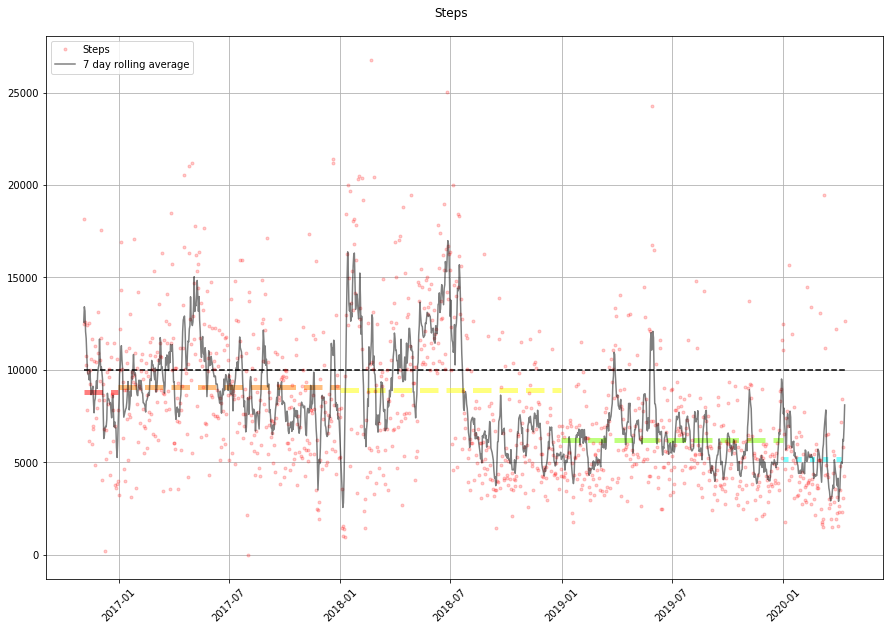

In [184]:
plt.figure(figsize=[15,10])
plt.suptitle('Steps', fontsize=12, y=.92)
plt.grid(True)
plt.plot(steps_by_date2['Steps'], 'r.', alpha=0.2,label='Steps')
plt.plot(steps_by_date2['RollingMeanSteps'], c='k',label='7 day rolling average', alpha=0.5)
plt.hlines(10000,steps_by_date2.index.min(), steps_by_date2.index.max(), linestyles='dashed')

plt.hlines(steps_by_date2.resample('Y').mean().iloc[0,0],steps_by_date2.index.min(), steps_by_date2.resample('Y').mean().index[0], linestyles='dashed', colors=(1,0,0,0.5), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[1,0],steps_by_date2.resample('Y').mean().index[0], steps_by_date2.resample('Y').mean().index[1], linestyles='dashed', colors=(1,0.5,0,0.5), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[2,0],steps_by_date2.resample('Y').mean().index[1], steps_by_date2.resample('Y').mean().index[2], linestyles='dashed', colors=(1,1,0,0.5), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[3,0],steps_by_date2.resample('Y').mean().index[2], steps_by_date2.resample('Y').mean().index[3], linestyles='dashed', colors=(0.5,1,0,0.5), linewidths=(5,))
plt.hlines(steps_by_date2.resample('Y').mean().iloc[4,0],steps_by_date2.resample('Y').mean().index[3], steps_by_date2.index.max(), linestyles='dotted', colors=(0,1,1,0.5), linewidths=(5,))

plt.legend(loc=2)
plt.xticks(rotation=45)

plt.show()

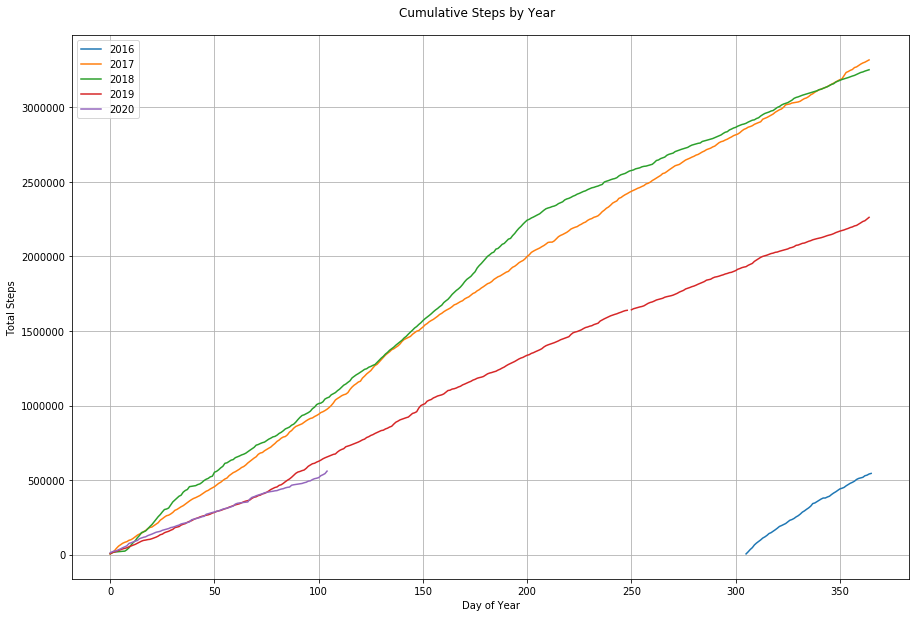

In [196]:
df = steps_by_date.copy()
df['date'] = pd.to_datetime(df['date'])
# fb['date'] = fb['Date'].dt.strftime('%Y-%m-%d')
# fb['year_month'] = fb['Date'].dt.strftime('%Y-%m')
df['year'] = df['date'].dt.year
# fb['month'] = fb['Date'].dt.month
# fb['day'] = fb['Date'].dt.day
# fb['dow'] = fb['Date'].dt.weekday
df['doy'] = df['date'].dt.dayofyear

steps_by_year = pd.pivot_table(df, index='doy', columns='year', values='Steps', aggfunc='sum').reset_index().rename_axis(None, axis=1)
# steps_by_year['2016cum']=steps_by_year['2016']


# print(steps_by_year[2016])


plt.figure(figsize=[15,10])
plt.suptitle('Cumulative Steps by Year', fontsize=12, y=.92)
plt.grid(True)
plt.plot(steps_by_year[2016].cumsum(), label='2016')
plt.plot(steps_by_year[2017].cumsum(), label='2017')
plt.plot(steps_by_year[2018].cumsum(), label='2018')
plt.plot(steps_by_year[2019].cumsum(), label='2019')
plt.plot(steps_by_year[2020].cumsum(), label='2020')

plt.ylabel("Total Steps")
plt.xlabel("Day of Year")
plt.legend(loc=2)
# plt.xticks(rotation=45)

plt.show()

In [197]:
### Steps needed to get on track

#Yearly averages
yearly_totals=steps_by_date2['Steps'].resample('Y').sum()

#Current DOY
doy = datetime.today().timetuple().tm_yday#.strftime('%Y-%m-%d')

print("To reach 10,000 steps per day I will need to walk", math.ceil((3652500-yearly_totals.iloc[-1])/(365.25-doy)), "steps per day for the rest of the year.")
print("To beat my", yearly_totals.index[1].year,"steps I will need to walk", math.ceil((yearly_totals.iloc[1]-yearly_totals.iloc[-1])/(365.25-doy)), "steps per day for the rest of the year.")
print("To beat my", yearly_totals.index[2].year,"steps I will need to walk", math.ceil((yearly_totals.iloc[2]-yearly_totals.iloc[-1])/(365.25-doy)), "steps per day for the rest of the year.")
print("To beat my", yearly_totals.index[3].year,"steps I will need to walk", math.ceil((yearly_totals.iloc[3]-yearly_totals.iloc[-1])/(365.25-doy)), "steps per day for the rest of the year.")

To reach 10,000 steps per day I will need to walk 12049 steps per day for the rest of the year.
To beat my 2017 steps I will need to walk 10761 steps per day for the rest of the year.
To beat my 2018 steps I will need to walk 10506 steps per day for the rest of the year.
To beat my 2019 steps I will need to walk 6687 steps per day for the rest of the year.


In [66]:
# #Write df to csv
# steps_by_date.to_csv("data/steps_per_day.csv", index=False)

------

## Monthly Steps

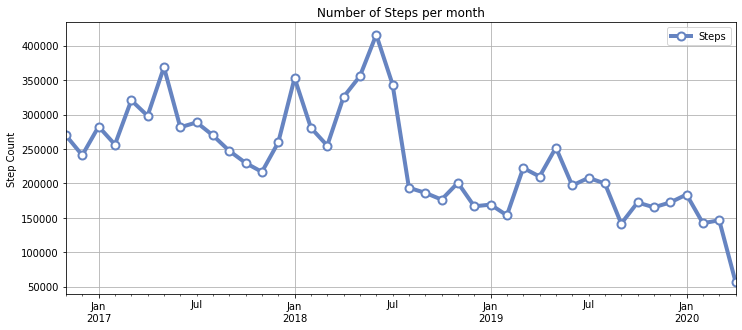

In [91]:
df = steps_by_date.drop('RollingMeanSteps', axis=1)
df = df.resample('M', on='date').sum()
# df.head()

chart_title = 'Number of Steps per month'

ax = df.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=1, marker='o', color='#6684c1', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylabel('Step Count')
ax.set_xlabel('')
ax.set_title(chart_title)

plt.show()

## Steps By Year

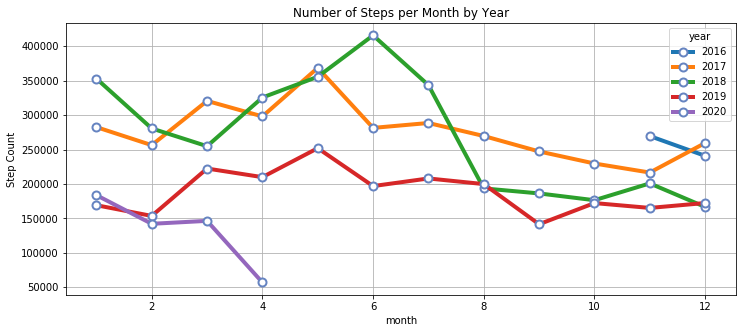

In [93]:
# Group data by year in pivot table
df2 = steps_by_date.drop(['RollingMeanSteps'], axis=1)
df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month

df3 = pd.pivot_table(df2, index='month', columns='year', values='Steps', aggfunc='sum')
chart_title = 'Number of Steps per Month by Year'

ax = df3.plot(kind='line', figsize=[12, 5], linewidth=4, alpha=1, marker='o', 
                      markeredgecolor='#6684c1', markerfacecolor='w', markersize=8, markeredgewidth=2)

ax.yaxis.grid(True)
ax.xaxis.grid(True)
ax.set_ylabel('Step Count')
ax.set_title(chart_title)

plt.show()

----

-----

## Weight Data

In [124]:
#import apple data
weight = pd.read_csv("data/BodyMass.csv")
#keep only apple health data (the rest are copies)
weight = weight[weight.sourceName=='Health']
#sort and reindex
weight = weight.sort_values(by='startDate', ignore_index=True)

# parse out date and time elements as EST time
weight['startDate'] = pd.to_datetime(weight['startDate'], utc=True).dt.tz_convert('EST')
weight['endDate'] = pd.to_datetime(weight['endDate'], utc=True).dt.tz_convert('EST')
weight['date'] = weight['startDate'].dt.strftime('%Y-%m-%d')

# drop duplicates
weight.drop_duplicates(subset = 'date', keep='last', ignore_index=True, inplace=True)

#drop irrelevant columns and rename value to Weight
weight = weight[['value','date']]
weight.rename(columns={'value':'Weight'}, inplace=True)

# weight.head(10)

In [125]:
#import fitbit weight data
weight2 = pd.read_csv("data/fitbit_weight.csv")

weight2['Date'] = pd.to_datetime(weight2['Date'])
weight2['date'] = weight2['Date'].dt.strftime('%Y-%m-%d')
weight2 = weight2.drop(['Date','BMI'], axis=1)

# weight2.head(10)

In [126]:
#merge with fitbit data
# print(weight.shape)
weight = pd.concat([weight2,weight], ignore_index=True)
# print(weight.shape)

In [135]:
weight.tail()

,Weight,date
211,204.2,2020-03-10
212,204.1,2020-03-11
213,203.5,2020-03-12
214,204.1,2020-03-13
215,201.8,2020-04-14


(1110, 1)


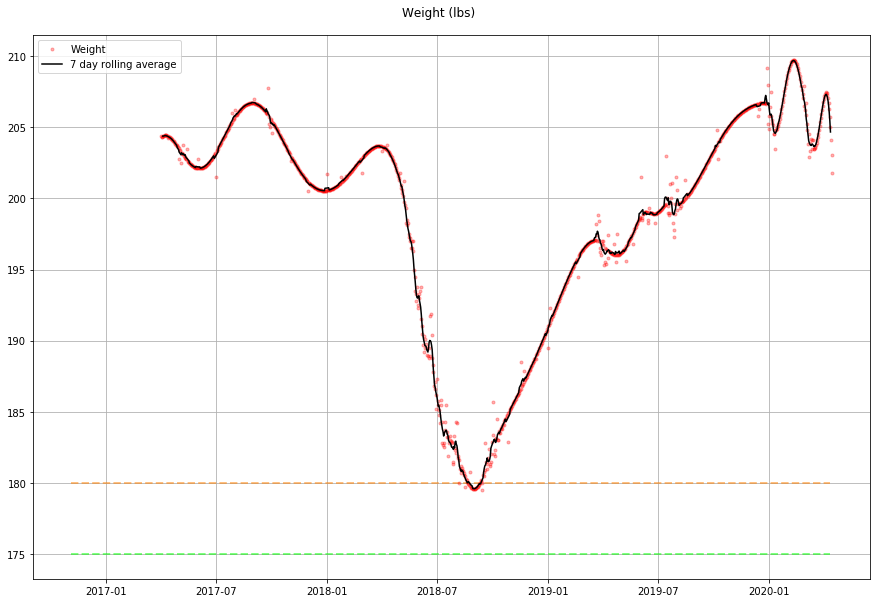

In [193]:
# parse out date and time elements
weight3 =weight.copy()
weight3['Date'] = pd.to_datetime(weight3['date'])

#sort by date and reindex
weight3 = weight3.sort_values(by='Date', ignore_index=True)

#set Date as index
weight3 = weight3.drop('date', axis=1).set_index('Date')

#resample by day and interpolate missing values using splines
weight3 = weight3.resample('D').interpolate(method='spline', order = 4, axis = 0)
print(weight3.shape)

#create a 7day rolling average
weight3['rolling_avg']=weight3.rolling(window=7, center=True).mean()

#plot it
plt.figure(figsize=[15,10])
plt.suptitle('Weight (lbs)', fontsize=12, y=.92)
plt.grid(True)
plt.plot(weight3['Weight'], 'r.', alpha=0.3,label='Weight')
plt.plot(weight3['rolling_avg'], c='k',label='7 day rolling average')

plt.hlines(180,steps_by_date2.index.min(), steps_by_date2.index.max(), linestyles='dashed', colors=(1,.5,0,0.5), linewidths=(2,))
plt.hlines(175,steps_by_date2.index.min(), steps_by_date2.index.max(), linestyles='dashed', colors=(0,1,0,0.5), linewidths=(2,))

plt.legend(loc=2)

plt.show()

(37, 1)


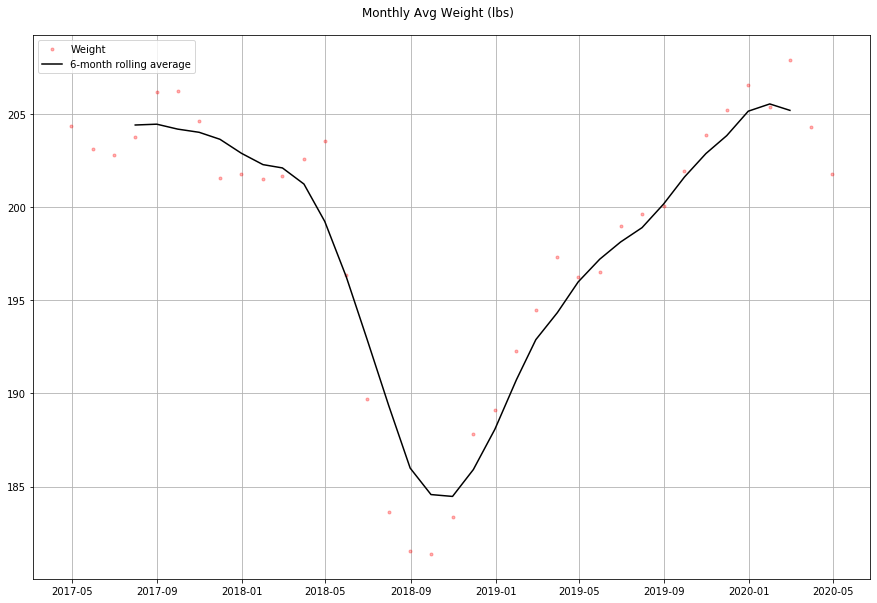

In [187]:
# parse out date and time elements
weight2 =weight.copy()
weight2['Date'] = pd.to_datetime(weight2['date'])

#sort by date and reindex
weight2 = weight2.sort_values(by='Date', ignore_index=True)

#set Date as index
weight2 = weight2.drop('date', axis=1).set_index('Date')

#resample by day and interpolate missing values using splines
weight2 = weight2.resample('M').mean().interpolate(method='linear', axis = 0)
print(weight2.shape)

#create a 6-month rolling average
weight2['rolling_avg']=weight2.rolling(window=6, center=True).mean()

plt.figure(figsize=[15,10])
plt.suptitle('Monthly Avg Weight (lbs)', fontsize=12, y=.92)
plt.grid(True)
plt.plot(weight2['Weight'], 'r.', alpha=0.3,label='Weight')
plt.plot(weight2['rolling_avg'], c='k',label='6-month rolling average')
plt.legend(loc=2)
# plt.xticks(rotation=45)

plt.show()

## Heart Rate

In [204]:
resting = pd.read_csv("data/RestingHeartRate.csv")
# len(resting)

In [200]:
# resting.head()
resting.tail()

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value
0,Greg’s Apple Watch,4.3,NaN,RestingHeartRate,count/min,2018-06-18 08:20:52 -0400,2018-06-17 16:02:25 -0400,2018-06-17 22:44:25 -0400,59
1,Greg’s Apple Watch,4.3,NaN,RestingHeartRate,count/min,2018-06-18 19:12:01 -0400,2018-06-18 06:19:40 -0400,2018-06-18 19:07:04 -0400,53
2,Greg’s Apple Watch,4.3,NaN,RestingHeartRate,count/min,2018-06-19 20:23:10 -0400,2018-06-19 06:33:01 -0400,2018-06-19 20:10:06 -0400,57
3,Greg’s Apple Watch,4.3.1,NaN,RestingHeartRate,count/min,2018-06-21 22:35:12 -0400,2018-06-21 06:32:57 -0400,2018-06-21 22:03:29 -0400,54
4,Greg’s Apple Watch,4.3.1,NaN,RestingHeartRate,count/min,2018-06-21 22:35:14 -0400,2018-06-20 06:35:03 -0400,2018-06-20 22:06:57 -0400,57


In [201]:
resting.sourceName.unique()

array(['Greg’s Apple\xa0Watch'], dtype=object)

In [202]:
# # parse out date and time elements as EST time
# resting['startDate'] = pd.to_datetime(resting['startDate'])
# resting['year'] = resting['startDate'].map(get_year)
# resting['month'] = resting['startDate'].map(get_month)
# resting['date'] = resting['startDate'].map(get_date)

# parse out date and time elements as EST time
resting['startDate'] = pd.to_datetime(resting['startDate'], utc=True).dt.tz_convert('EST')
resting['endDate'] = pd.to_datetime(resting['endDate'], utc=True).dt.tz_convert('EST')
resting['year'] = resting['startDate'].dt.year
resting['month'] = resting['startDate'].dt.strftime('%Y-%m')
resting['date'] = resting['startDate'].dt.strftime('%Y-%m-%d')
resting['day'] = resting['startDate'].dt.day
resting['hour'] = resting['startDate'].dt.hour
resting['dow'] = resting['startDate'].dt.weekday

resting.drop(['device', 'creationDate'], axis=1)

,sourceName,sourceVersion,type,unit,startDate,endDate,value,year,month,date,day,hour,dow
0,Greg’s Apple Watch,4.3,RestingHeartRate,count/min,2018-06-17 15:02:25-05:00,2018-06-17 21:44:25-05:00,59,2018,2018-06,2018-06-17,17,15,6
1,Greg’s Apple Watch,4.3,RestingHeartRate,count/min,2018-06-18 05:19:40-05:00,2018-06-18 18:07:04-05:00,53,2018,2018-06,2018-06-18,18,5,0
2,Greg’s Apple Watch,4.3,RestingHeartRate,count/min,2018-06-19 05:33:01-05:00,2018-06-19 19:10:06-05:00,57,2018,2018-06,2018-06-19,19,5,1
3,Greg’s Apple Watch,4.3.1,RestingHeartRate,count/min,2018-06-21 05:32:57-05:00,2018-06-21 21:03:29-05:00,54,2018,2018-06,2018-06-21,21,5,3
4,Greg’s Apple Watch,4.3.1,RestingHeartRate,count/min,2018-06-20 05:35:03-05:00,2018-06-20 21:06:57-05:00,57,2018,2018-06,2018-06-20,20,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,Greg’s Apple Watch,6.1.3,RestingHeartRate,count/min,2020-04-10 06:42:15-05:00,2020-04-10 20:30:16-05:00,55,2020,2020-04,2020-04-10,10,6,4
662,Greg’s Apple Watch,6.1.3,RestingHeartRate,count/min,2020-04-11 08:11:34-05:00,2020-04-11 09:22:53-05:00,59,2020,2020-04,2020-04-11,11,8,5
663,Greg’s Apple Watch,6.1.3,RestingHeartRate,count/min,2020-04-12 07:20:54-05:00,2020-04-12 16:54:11-05:00,58,2020,2020-04,2020-04-12,12,7,6
664,Greg’s Apple Watch,6.1.3,RestingHeartRate,count/min,2020-04-14 05:50:58-05:00,2020-04-14 16:45:16-05:00,57,2020,2020-04,2020-04-14,14,5,1


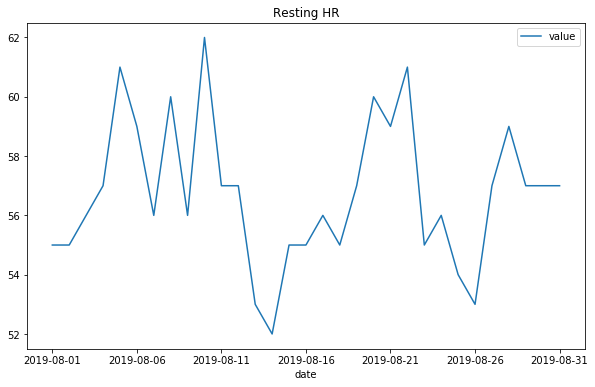

In [203]:
resting[resting.month == '2019-08'].plot(x='date', y='value', title= 'Resting HR', figsize=[10, 6])

In [ ]:
hr = pd.read_csv("data/HeartRate.csv")
len(hr)

In [ ]:
# hr.tail(10)

In [ ]:
# # parse out date and time elements as EST time
# hr['startDate'] = pd.to_datetime(hr['startDate'])
# hr['year'] = hr['startDate'].map(get_year)
# hr['month'] = hr['startDate'].map(get_month)
# hr['hour'] = hr['startDate'].map(get_hour)
# hr['date'] = hr['startDate'].map(get_date)


# parse out date and time elements as EST time
hr['startDate'] = pd.to_datetime(hr['startDate'], utc=True).dt.tz_convert('EST')
hr['endDate'] = pd.to_datetime(hr['endDate'], utc=True).dt.tz_convert('EST')
hr['year'] = hr['startDate'].dt.year
hr['month'] = hr['startDate'].dt.strftime('%Y-%m')
hr['date'] = hr['startDate'].dt.strftime('%Y-%m-%d')
hr['day'] = hr['startDate'].dt.day
hr['hour'] = hr['startDate'].dt.hour
hr['dow'] = hr['startDate'].dt.weekday

hr.drop(['device', 'creationDate'], axis=1)

In [ ]:
# plot a single day
test_date = '2019-08-28'
# len(hr[hr.date == test_date])
# TODO: Fix Axis for Hour of Day or Something Similar
hr[hr.date == test_date].plot(x='startDate', y='value', title= 'HR', figsize=[10, 6])

------